In [1]:
import baccoemu
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import scipy
import warnings

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plot_utils
import plotter
import utils
import data_loader

%load_ext autoreload
%autoreload 2

2025-02-11 23:13:13.125251: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 23:13:13.226049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-11 23:13:13.226087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-11 23:13:13.239264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 23:13:13.269664: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

In [3]:
plot_dir = '../plots/plots_2025-01-23'
save_plots = False

## Load data

In [4]:
data_mode = 'emuPk'
assert data_mode in ['emuPk', 'muchisimocksPk']

idxs_obs = [0]

In [5]:
data_mode = 'emuPk'
#tag_params = '_p2_n10000' 
tag_params = '_quijote_p0_n1000'
tag_biasparams = '_b1000_p0_n1'
n_rlzs_per_cosmo = 1
tag_errG = '_boxsize1000'
#tag_noiseless = ''
tag_noiseless = '_noiseless' # for emulator, probs want to use noiseless rather than evaluate mean
tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
tag_data = '_'+data_mode + tag_params + tag_biasparams + tag_datagen + tag_noiseless

# for likelihood methods, we decide which parameters to sample over! 
# (will have to change when have a test set not generated with these params, e.g. hydro)
cosmo_param_names_vary = ['omega_cold', 'sigma8_cold']
#cosmo_param_names_vary = ['omega_cold', 'sigma8_cold', 'hubble', 'ns', 'omega_baryon']
bias_param_names_vary = []
tag_inf = f'{tag_data}_mcmctest_p{len(cosmo_param_names_vary)}_b{len(bias_param_names_vary)}'

In [6]:
param_names_vary = cosmo_param_names_vary + bias_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams)
# for when have a LH
if 'p0' in tag_params and 'p0' in tag_biasparams:
    theta_test = [param_dict_fixed[pname] for pname in cosmo_param_names_vary]
    theta_test.extend([biasparams_dict_fixed[pname] for pname in bias_param_names_vary])
    theta_test = np.repeat(theta_test, len(idxs_obs))
    theta_test = np.atleast_2d(theta_test)
else:
    theta_test, param_names = data_loader.param_dfs_to_theta(params_df, biasparams_df, n_rlzs_per_cosmo=n_rlzs_per_cosmo)
    assert param_names == param_names_vary, "param_names_vary and param_names should match! something wrong"

[0.3175 0.834 ]
['omega_cold', 'sigma8_cold']
[[[0.31760725 0.8349237 ]
  [0.32487142 0.83552957]
  [0.3154569  0.832608  ]
  ...
  [0.32290924 0.834472  ]
  [0.32400885 0.83734083]
  [0.30802009 0.8314252 ]]

 [[0.32500347 0.83747977]
  [0.3057848  0.8316199 ]
  [0.308216   0.8321374 ]
  ...
  [0.31963918 0.8353872 ]
  [0.3257695  0.8363882 ]
  [0.3131502  0.8323131 ]]

 [[0.32130247 0.833074  ]
  [0.31391057 0.8340514 ]
  [0.32463637 0.835136  ]
  ...
  [0.31474802 0.833502  ]
  [0.31952888 0.83491474]
  [0.3157842  0.83424705]]

 ...

 [[0.3143036  0.83311623]
  [0.32460046 0.834521  ]
  [0.31239778 0.83252954]
  ...
  [0.31577533 0.8329511 ]
  [0.32700434 0.83658063]
  [0.3103798  0.8316854 ]]

 [[0.31324142 0.83436173]
  [0.3143748  0.83366567]
  [0.31657767 0.8338865 ]
  ...
  [0.3268761  0.8339943 ]
  [0.3191484  0.8352364 ]
  [0.31265926 0.833285  ]]

 [[0.32275623 0.83650434]
  [0.31639287 0.8337289 ]
  [0.322411   0.83639467]
  ...
  [0.32221016 0.83613837]
  [0.31453452 0.83

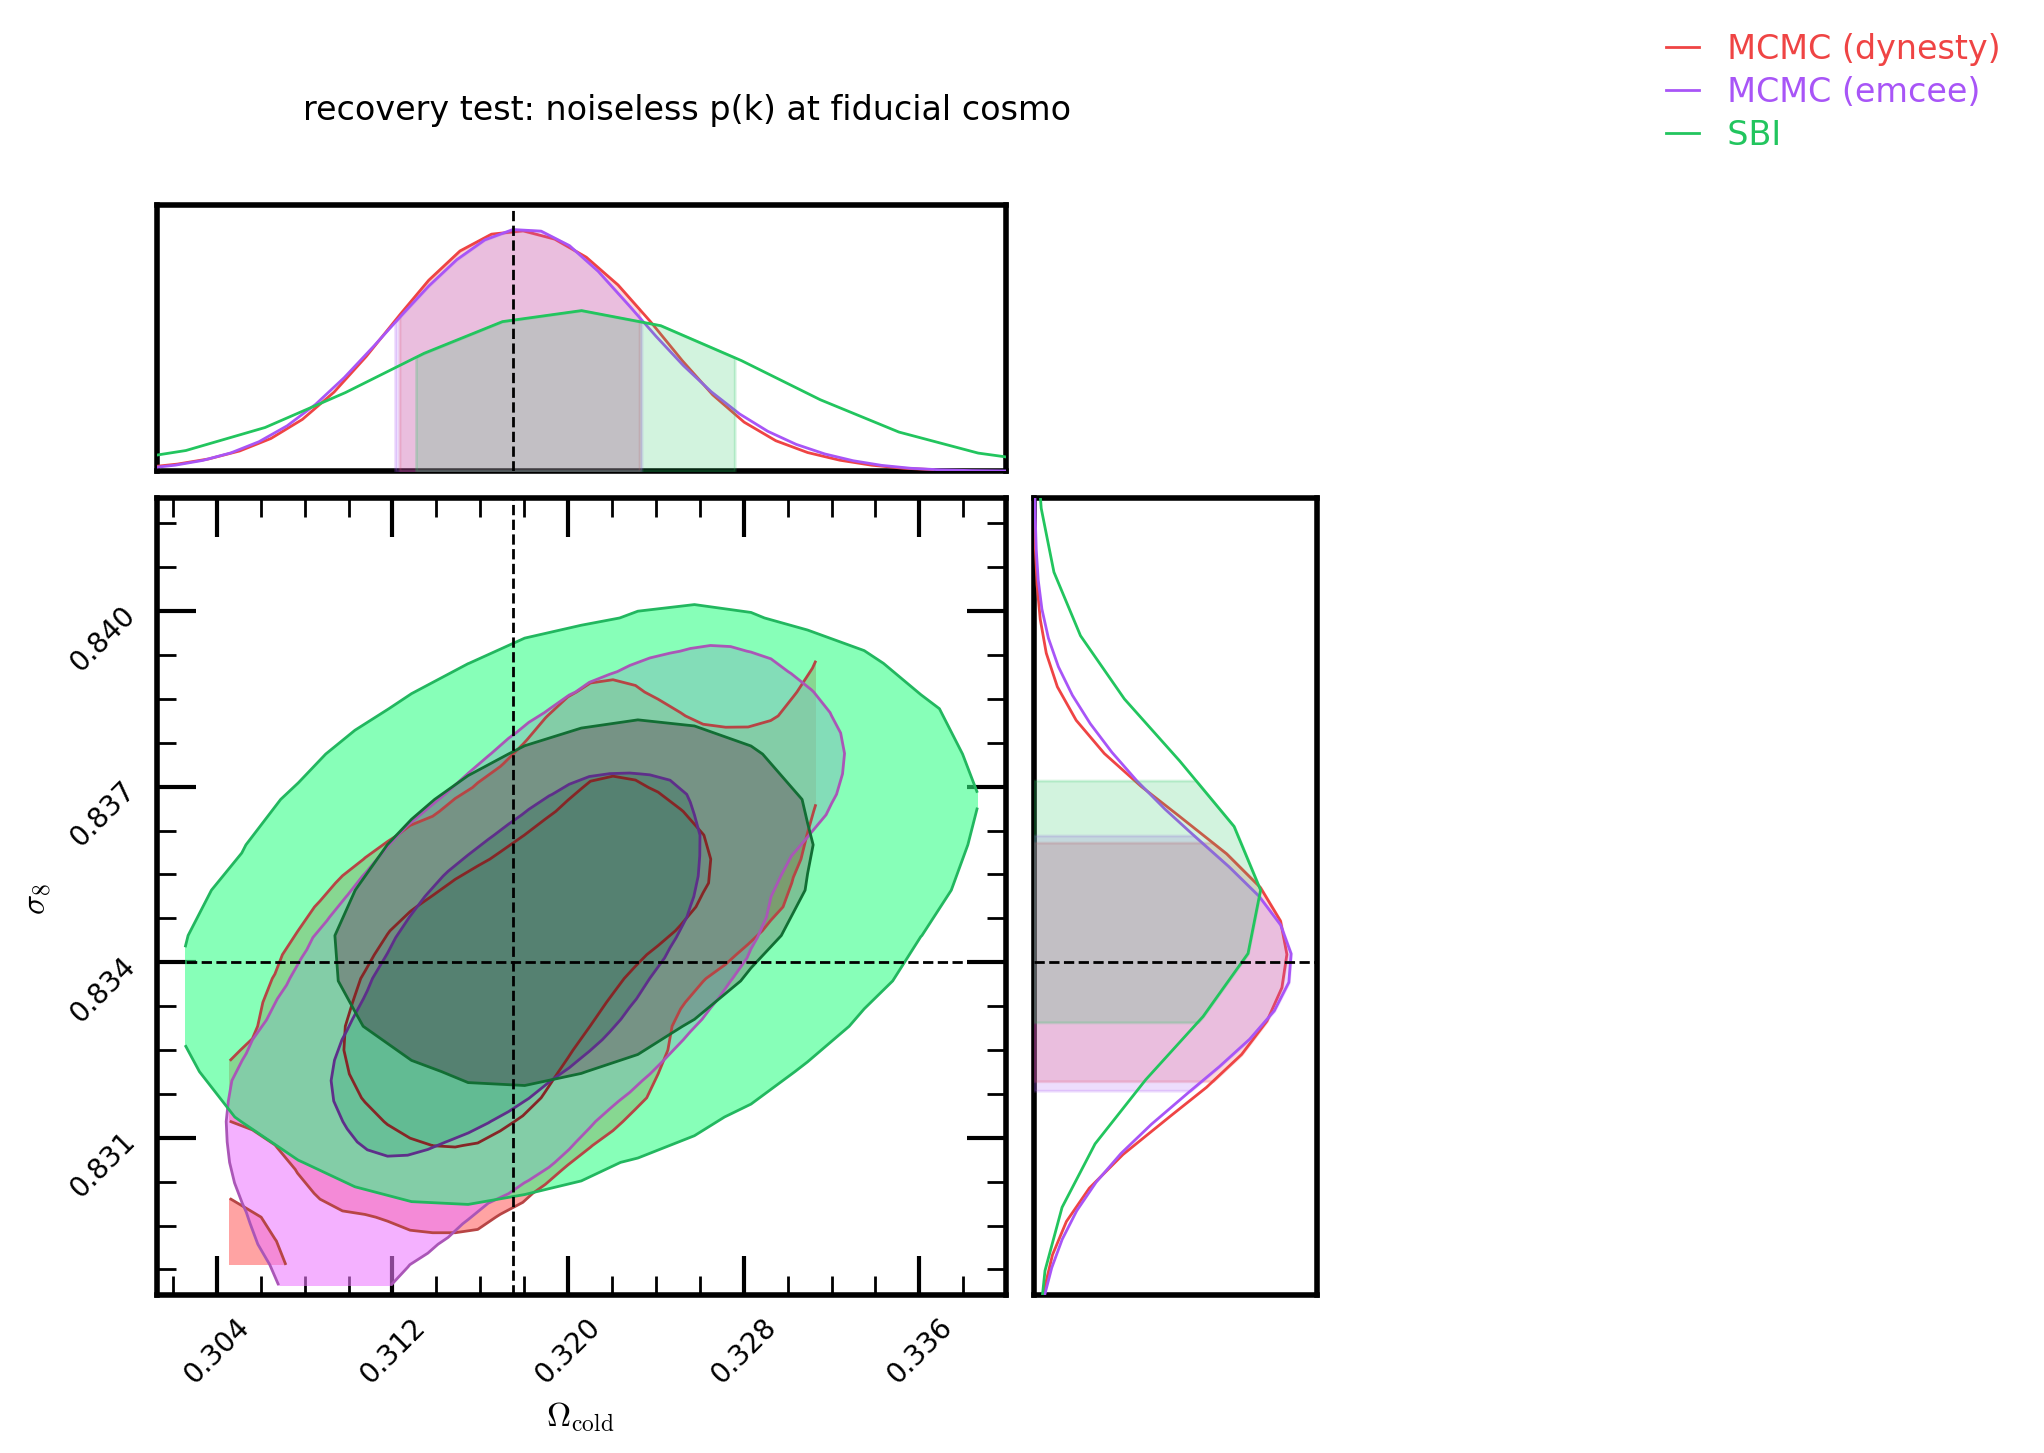

In [7]:
inf_methods = [
               'dynesty',
               'emcee',
               'sbi'
              ]
tags_inf = [
            tag_inf,
            tag_inf,
            '_emuPk_p2_n10000_b1000_p0_n1_boxsize1000_nrlzs1_ntrain9000'
            ]
tags_test = [
             None,
             None,
             '_emuPk_p2_n10000_b1000_p0_n1_boxsize1000_nrlzs1'
            ]

labels_extra = [
                '',
                '',
                '',
                ]
title = 'recovery test: noiseless p(k) at fiducial cosmo'

colors = [utils.color_dict_methods[meth] for meth in inf_methods]
#colors = ['#63E0CF', 'cyan', 'blue', '#2E3CA2']
#colors[1] = 'purple'

for idx_obs in [0]:
    theta_obs_true = theta_test[idx_obs]
    #theta_obs_true = theta_test
    print(theta_obs_true)
    print(param_names_vary)
    plotter.plot_contours_inf(param_names_vary, idx_obs, theta_obs_true, 
                            inf_methods, tags_inf, tags_test=tags_test,
                            colors=colors, labels_extra=labels_extra,
                            title=title)

# p5

In [8]:
data_mode = 'emuPk'
#tag_params = '_p2_n10000' 
tag_params = '_quijote_p0_n1000'
tag_biasparams = '_b1000_p0_n1'
n_rlzs_per_cosmo = 1
tag_errG = '_boxsize1000'
#tag_noiseless = ''
tag_noiseless = '_noiseless' # for emulator, probs want to use noiseless rather than evaluate mean
tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
tag_data = '_'+data_mode + tag_params + tag_biasparams + tag_datagen + tag_noiseless

# for likelihood methods, we decide which parameters to sample over! 
# (will have to change when have a test set not generated with these params, e.g. hydro)
#cosmo_param_names_vary = ['omega_cold', 'sigma8_cold']
cosmo_param_names_vary = ['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns']
bias_param_names_vary = []
tag_inf = f'{tag_data}_mcmctest_p{len(cosmo_param_names_vary)}_b{len(bias_param_names_vary)}'

In [9]:
param_names_vary = cosmo_param_names_vary + bias_param_names_vary
print(param_names_vary)
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams)
# for when have a LH
if 'p0' in tag_params and 'p0' in tag_biasparams:
    theta_test = [param_dict_fixed[pname] for pname in cosmo_param_names_vary]
    theta_test.extend([biasparams_dict_fixed[pname] for pname in bias_param_names_vary])
    theta_test = np.repeat(theta_test, len(idxs_obs))
    theta_test = np.atleast_2d(theta_test)
    print(theta_test)
else:
    theta_test, param_names = data_loader.param_dfs_to_theta(params_df, biasparams_df, n_rlzs_per_cosmo=n_rlzs_per_cosmo)
    assert param_names == param_names_vary, "param_names_vary and param_names should match! something wrong"

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns']
[[0.3175 0.834  0.6711 0.049  0.9624]]


### Check SBI training

In [10]:
import pickle
tag_inf_sbi = '_emuPk_p5_n10000_b1000_p0_n1_boxsize1000_nrlzs1_ntrain9000'
dir_sbi = f'../results/results_sbi/sbi{tag_inf_sbi}'

fn_inference = f'{dir_sbi}/inference.p'
with open(fn_inference, "rb") as f:
    inference = pickle.load(f)

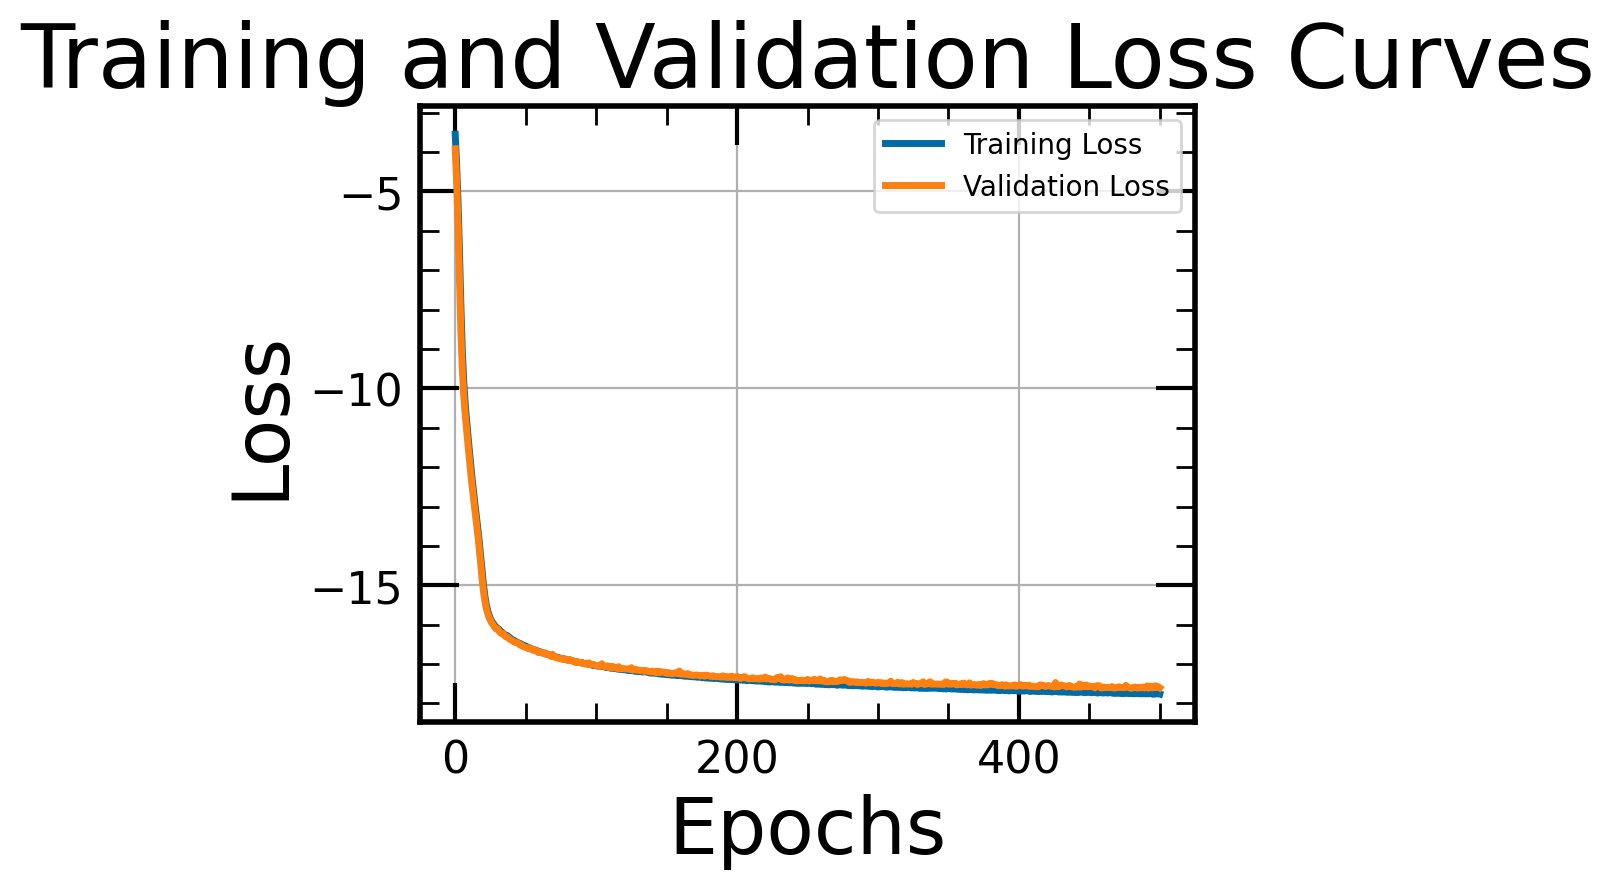

In [11]:
# Extract training and validation loss
training_loss = inference._summary["training_loss"]
validation_loss = inference._summary["validation_loss"]

# Plot the loss curves
plt.figure(figsize=(5, 4))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend(fontsize=10)
plt.grid(True)

[0.3175 0.834  0.6711 0.049  0.9624]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns']
[[[0.31083915 0.8348353  0.68071043 0.05440163 0.9885918 ]]

 [[0.3291963  0.83663756 0.6560548  0.05628721 0.9796894 ]]

 [[0.33522832 0.8339533  0.65980846 0.0571229  0.9445086 ]]

 ...

 [[0.3104778  0.83245695 0.6934463  0.04472271 0.9454295 ]]

 [[0.3203442  0.83085746 0.70443785 0.05216657 0.92924505]]

 [[0.32178807 0.8362989  0.6429538  0.05086654 1.0031997 ]]]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns']
(10000, 5)


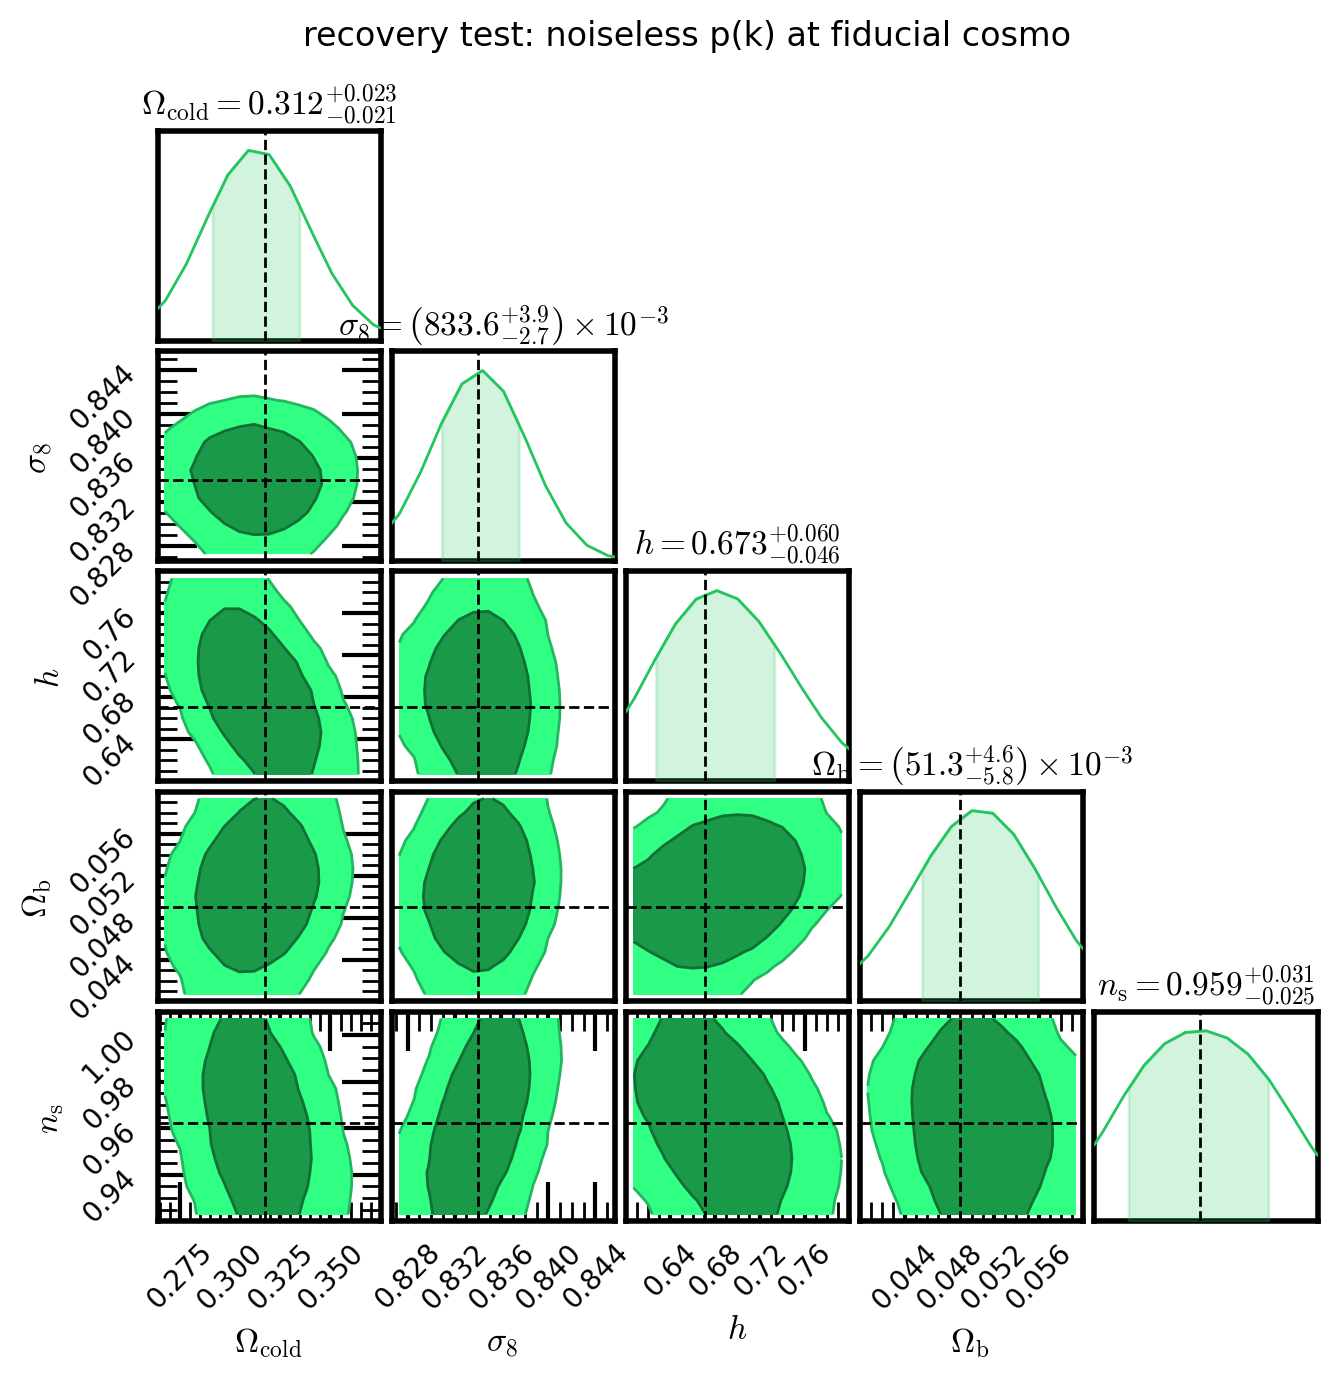

In [12]:
# TODO make these tags fill in w the tags above!
inf_methods = [
               #'dynesty',
               'sbi'
              ]
tags_inf = [
            #tag_inf,
            tag_inf_sbi,
            ]
tags_test = [
             #None,
             '_emuPk_p5_n10000_b1000_p0_n1_boxsize1000_nrlzs1_noiseless'
            ]

labels_extra = [
                '',
                '',
                ]
title = 'recovery test: noiseless p(k) at fiducial cosmo'
colors = [utils.color_dict_methods[meth] for meth in inf_methods]
#colors = ['#63E0CF', 'cyan', 'blue', '#2E3CA2']
#colors[1] = 'purple'

for idx_obs in [0]:
    theta_obs_true = theta_test[idx_obs]
    #theta_obs_true = theta_test
    print(theta_obs_true)
    print(param_names_vary)
    plotter.plot_contours_inf(param_names_vary, idx_obs, theta_obs_true, 
                            inf_methods, tags_inf, tags_test=tags_test,
                            colors=colors, labels_extra=labels_extra,
                            title=title)